# Humanoid tasks
This tutorial is based on the Deepmind tutorials for humanoid balancing:

https://github.com/google-deepmind/mujoco

a CMU optimial control course homework:

https://github.com/Optimal-Control-16-745/HW1_S24_solutions/blob/main/Q2.ipynb

We explore contact dynamics, nonconvex optimization and more model-based control methods in this tutorials 

In [1]:
import mujoco
import mujoco.minimize
import mediapy as media
import numpy as np
import cvxpy as cp


## Load the model

""

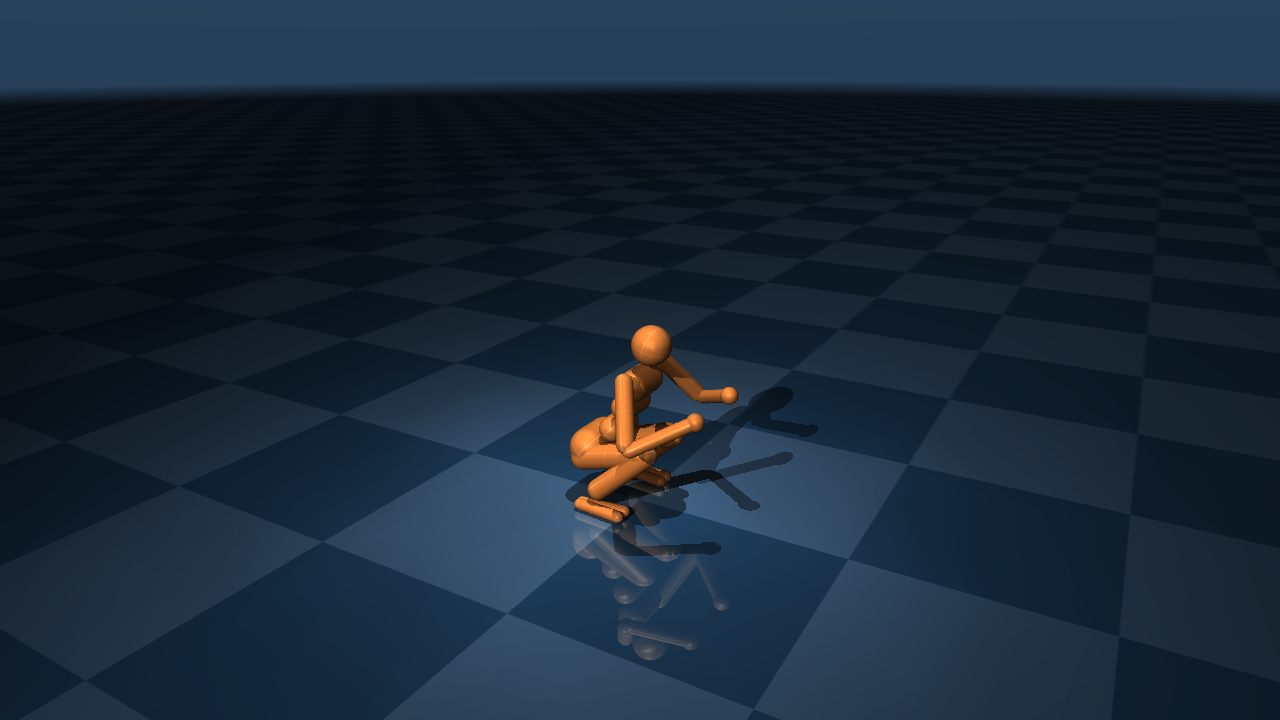

In [2]:
xml_path = "./humanoid/humanoid.xml"

model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)

# Get the initial frame ID
key_id = model.key("squat").id

# Reset the simulation to the initial keyframe.
mujoco.mj_resetDataKeyframe(model, data, key_id)

renderer = mujoco.Renderer(model, width=1280, height=720)
scene_option = mujoco.MjvOption()
mujoco.mjv_defaultOption(scene_option)
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.frame = mujoco.mjtFrame.mjFRAME_WORLD

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [9]:
duration = 10 # (seconds)
framerate = 30  # (Hz)
frames = []
mujoco.mj_resetDataKeyframe(model, data, key_id)
mujoco.mj_forward(model, data)

while data.time < duration:

    mujoco.mj_step(model, data)

    # Updates the trajs
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        # Draw the scenes
        pixels = renderer.render()
        frames.append(pixels)
media.show_video(frames, fps=framerate)

## Contact force visualization
Mujoco embed many functions and fields for contact. We will play with them around in this sections

Let's first visualize the contact for the initial postures

""

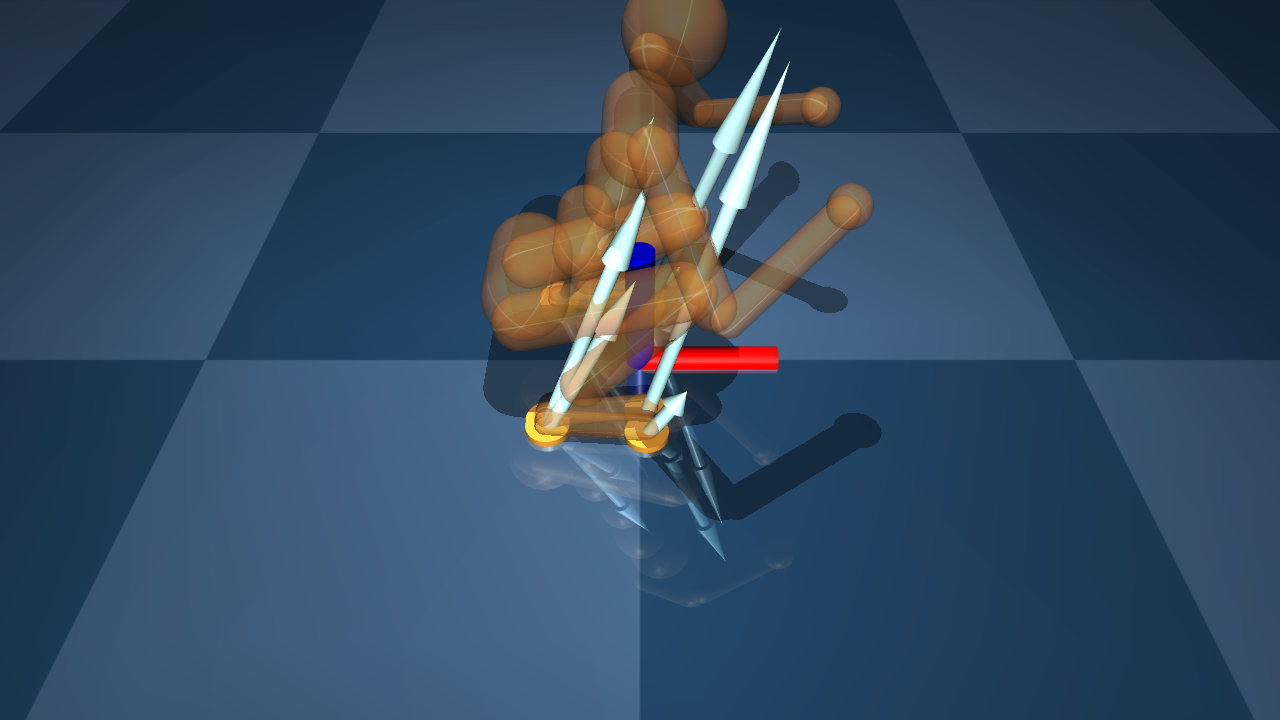

""

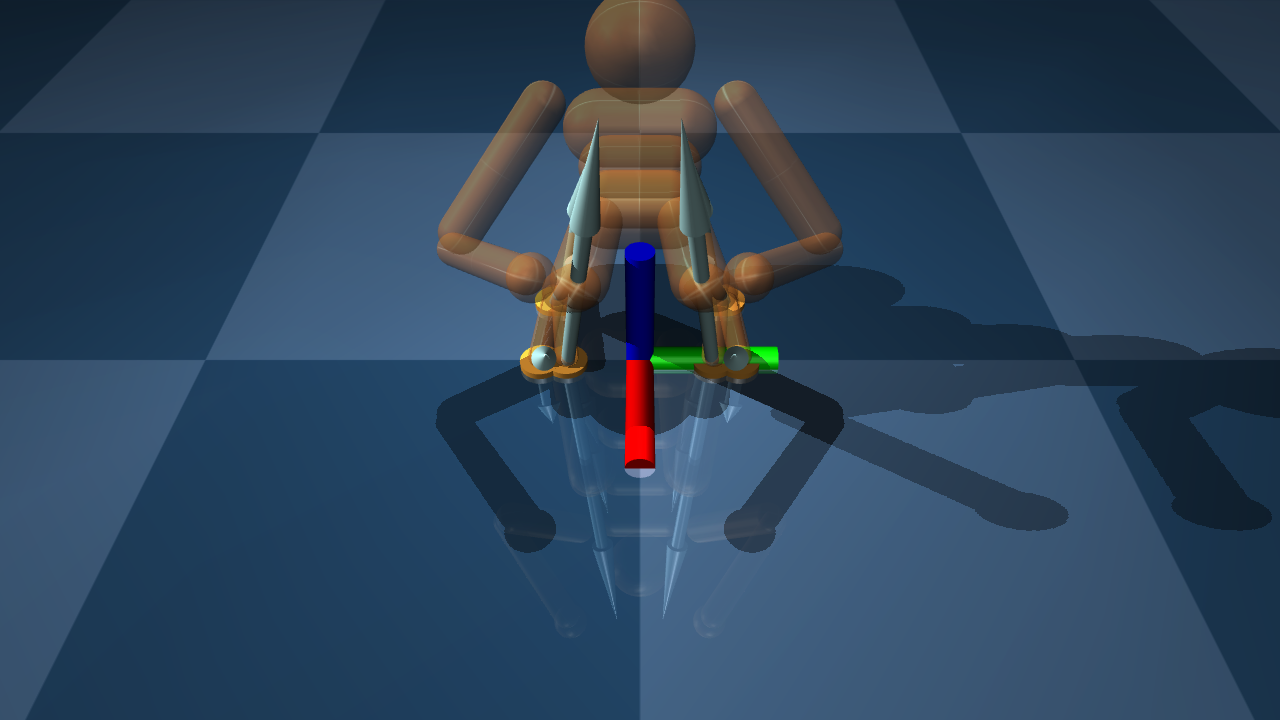

In [4]:
mujoco.mj_resetDataKeyframe(model, data, key_id)

cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)

mujoco.mj_forward(model, data)

cam.azimuth = 90
renderer.update_scene(data, camera=cam, scene_option=scene_option)
media.show_image(renderer.render())

cam.azimuth = 180
renderer.update_scene(data, camera=cam, scene_option=scene_option)
media.show_image(renderer.render())


Let's retrives information about contact. This is stored in the data.contact.

In [5]:
total_contact_force_in_world_frame = np.zeros(3)
for (i, contact) in enumerate(data.contact):
    # contact.geom stored which two geometries contact
    print(f"Contacts happen between '{model.geom(contact.geom[0]).name}' and '{model.geom(contact.geom[1]).name}'")
    # contact.pos is location where contact happen, this is expressed in world frame
    print(f"Contact location is{contact.pos}")
    # contact.frame store orientation of contact frame which can be reshape as rotation matrix. 
    # The first column is always contact normal direction point from geom0 to geom1
    contact_frame = (contact.frame.reshape(3,3)).T
    print(f"Contact frame is: \n{contact_frame}")
    # Contact force can be obtain by mujoco.mj_Contactforce.
    # The force is expressed in the contact frame instead of world frame
    contact_force_torque = np.zeros(6)
    mujoco.mj_contactForce(model, data, i, contact_force_torque)
    contact_force_in_contact_frame = contact_force_torque[:3]
    print("Contact force in contact frame:", contact_force_in_contact_frame)
    # We obtain the contact force in the world frame by multiply rotation matrix(contact frame)
    contact_force_in_world_frame = contact_frame @ contact_force_in_contact_frame
    print("Contact force in world frame:", contact_force_in_world_frame)
    total_contact_force_in_world_frame += contact_force_in_world_frame
    print("")

Contacts happen between 'floor' and 'foot1_right'
Contact location is[-1.96230168e-01 -2.10098884e-01 -5.51367180e-05]
Contact frame is: 
[[ 0.         -0.99702939 -0.07702206]
 [ 0.          0.07702206 -0.99702939]
 [ 1.          0.          0.        ]]
Contact force in contact frame: [16.56214155 -9.16531569 -6.11103814]
Contact force in world frame: [ 9.60877385  5.38695311 16.56214155]

Contacts happen between 'floor' and 'foot1_right'
Contact location is[ 1.40933863e-02 -2.26346704e-01 -1.06808830e-04]
Contact frame is: 
[[ 0.         -0.99702939 -0.07702206]
 [ 0.          0.07702206 -0.99702939]
 [ 1.          0.          0.        ]]
Contact force in contact frame: [ 5.6681107  -4.09138439 -1.5767263 ]
Contact force in world frame: [4.20067319 1.2569156  5.6681107 ]

Contacts happen between 'floor' and 'foot2_right'
Contact location is[-1.96587241e-01 -1.90102121e-01 -7.72871453e-05]
Contact frame is: 
[[ 0.         -0.99364431  0.11256549]
 [ 0.         -0.11256549 -0.9936443

In [6]:
print("total contact force in world frame:", total_contact_force_in_world_frame)
print("total gravity of the humanoid:", np.sum(model.body_mass) * model.opt.gravity)

total contact force in world frame: [7.42922875e+01 4.50750548e-14 1.79934451e+02]
total gravity of the humanoid: [   0.            0.         -400.67984818]


## Make the robot maintaining squat postures
The humanoid dynamics can be written as 
$$M(q) \ddot{q} + \text{bias}(q, \dot{q}) = B(q) \text{ctrl}  + J^T(q)  \lambda, $$
where $M$ is mass matrix, bias includes the gravity and coriolis force, $B$ is the actuation matrix maps the control to the torque, and J is the contact jocobian.

The first question we facing is how to deal with the contact force $\lambda$, which can vary given different control

If no slip, the contact location should remain the stationary. This introduce another contraints that velocity of contact point in the world frame shoud be zero: $J \dot{q} = 0$. More importantly, this also implies the higher order acceleration is always zero $\dot{(J \dot{q})} = \dot{J} \dot{q} + J \ddot{q} = 0$. With $\dot{q} = 0$, this simply implies the $J \ddot{q} = 0$.

With the dynamics before we have the following linear equations:
$$
\begin{bmatrix}
M, J^T \\
J, 0
\end{bmatrix} \begin{bmatrix}\ddot{q}\\ \lambda \end{bmatrix} = \begin{bmatrix}B \ \text{ctrl}  - \text{bias}\\ 0 \end{bmatrix}.
$$
Note the Jacobian matrix can be neither column nor row full rank. None full row rank of Jacobian implies there are redundancy in the contact points, i.e. you can have same joined force by distributed different contact forces in contact points.

Now let's solve for control:

We want to find `ctrl` such that $\ddot{q} = 0$, which implies $J^T \lambda = B \text{ctrl} - \text{bias}$. Let's ignore additional condition for contact force $\lambda$ for a moment, then with reformulation, we have
$$
[B, -J^T] \begin{bmatrix}\text{ctrl}\\ \lambda\end{bmatrix} = \text{bias}
$$

If the solution exists, we can simply solve the above equation to obtain `ctrl`.

In [7]:
# Reset the simulation to the initial keyframe.
mujoco.mj_resetDataKeyframe(model, data, key_id)
mujoco.mj_forward(model, data)

# Pre-allocated data
ncon = data.ncon
jac = np.zeros((ncon*3, model.nv))
M_inv = np.zeros((model.nv, model.nv))
tmp = np.zeros((3, model.nv))

# Get the contact jocabian
for (i, contact) in enumerate(data.contact):
    # The geom[0] should be floor, and the geom[1] should be part of the humonid
    contact_geom_id = contact.geom[1]
    mujoco.mj_jac(model, data, jac[i*3:(i+1)*3], tmp, contact.pos, model.geom_bodyid[contact_geom_id])

print("Number of contact:", ncon)
print("Rank of Jacobian matrix:", np.linalg.matrix_rank(jac))

# Solve the equation [B, -J^T][ctrl \lambda]^T = bias
# For simple motor actuators like the humanoid's, the actuation matrix B is simply actuator_moment.T
actuator_jac_matrix = np.hstack([data.actuator_moment.T, -jac.T])
# Solve the linear eqautions, the function will return min-norm solution if multiple solution or least-square solution if no solution
ctrl_contact = np.linalg.lstsq(actuator_jac_matrix, data.qfrc_bias, rcond=None)[0]
ctrl0 = ctrl_contact[:model.nu]
contact_frc = ctrl_contact[model.nu:]
print("Desired control:", ctrl0)
print("Contact force:", contact_frc)

# Verify whether we exactly solve [B, -J^T][ctrl \lambda]^T = bias
print("Residual:", actuator_jac_matrix @ ctrl_contact - data.qfrc_bias)

# Verify acceleration
mujoco.mj_solveM(model, data, M_inv, np.eye(model.nv))
mass_jac_matrix = np.vstack([
    np.hstack([np.linalg.inv(M_inv), jac.T]),
    np.hstack([jac, np.zeros((ncon*3, ncon*3))]) 
    ])
qacc = (np.linalg.pinv(mass_jac_matrix) @ np.hstack([data.actuator_moment.T @ ctrl0 - data.qfrc_bias, np.zeros(3*ncon)]))[:model.nv]
print("Acceleration:", qacc)

Number of contact: 8
Rank of Jacobian matrix: 12
Desired control: [-9.27111587e-14  4.87927208e-01 -1.70530257e-13  3.14732253e-01
  4.12212760e-01  2.02725797e-01  2.50521989e-01  6.94446837e-01
  1.85435653e-03  3.14732253e-01  4.12212760e-01  2.02725797e-01
  2.50521989e-01  6.94446837e-01  1.85435653e-03 -1.76939374e-01
  1.15092316e-01  3.65196250e-02 -1.76939374e-01  1.15092316e-01
  3.65196250e-02]
Contact force: [ 1.02191423e-02 -4.05064415e-03 -2.81129899e+01 -3.96015323e-04
 -1.23453352e-03 -7.22058910e+01  5.30757880e-03 -4.05586878e-03
 -2.80385305e+01 -1.51307058e-02 -1.25020739e-03 -7.19825126e+01
  5.30757880e-03  4.05586878e-03 -2.80385305e+01 -1.51307058e-02
  1.25020739e-03 -7.19825126e+01  1.02191423e-02  4.05064415e-03
 -2.81129899e+01 -3.96015323e-04  1.23453351e-03 -7.22058910e+01]
Residual: [-2.27402461e-13  4.35325734e-12 -6.82121026e-13  2.53308485e-12
  6.39488462e-14  5.77315973e-13 -3.08908454e-12  9.59232693e-14
 -6.07691675e-12 -1.03295150e-12 -3.21787041e

In [8]:
print(jac[0])
print(data.contact[0].efc_address)
print(data.efc_force.shape)
print(data.efc_J[data.contact[0].efc_address])

[ 1.          0.          0.         -0.06408392 -0.59605514  0.20008696
  0.20008696 -0.41339773 -0.13694273 -0.0717626   0.02928561 -0.22993401
  0.31246246 -0.10121511  0.00392857  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
0
(32,)
-0.9970293887449965


### Simulated with desired control

In [9]:
duration = 5 # (seconds)
framerate = 30  # (Hz)
frames = []
# mujoco.mj_resetDataKeyframe(model, data, key_id)

while data.time < duration:

    # Set the desired control
    data.ctrl = ctrl0

    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        # Draw the scenes
        pixels = renderer.render()
        frames.append(pixels)
media.show_video(frames, fps=framerate)

The contact force previous calculated is negative in z axis, which saying the ground is pull our humonid feet into it, let's fix this prorblem via optimization. 

We want the contact force along z axis is always positive. In addition we want the robot stay stationary, which implies $\text{residuals} = B \text{ctrl} - J^T \lambda - bias = 0$.


$
\begin{align}
\underset{\text{ctrl}, \lambda}{\text{minimize}} \quad & \|\lambda\|_2^2 \nonumber \\
s.t. \quad & \lambda_z \geq 0 \nonumber \\
    & \text{residuals} = 0. \nonumber
\end{align}
$

In [10]:
# Reset the simulation to the initial keyframe.
mujoco.mj_resetDataKeyframe(model, data, key_id)
mujoco.mj_forward(model, data)

# Define decision variables
ctrl_cp = cp.Variable(model.nu)
lam_cp = cp.Variable(ncon * 3)
residual = data.actuator_moment.T @ ctrl_cp - jac.T @ lam_cp - data.qfrc_bias
lam_z = lam_cp[2::3]

# Set objective to minimize residual to zero
obj = cp.Minimize(cp.sum(lam_cp ** 2))
# Set constaints 
# Contact force along z axis must be positive
# Residual must be zero,
constraints = [residual == 0, lam_z >= 0]
prob = cp.Problem(obj, constraints)
prob.solve()

print(prob.status)
print(ctrl_cp.value)
print(lam_z.value)

infeasible
None
None


Saddly, our optimization fail to find a feasible solution. Making the residual equal to zero and make the all contact force z axis positive conflict with each other.

### Find the configuration that can stand still

We want to solve optimization
$
\begin{align}
    \underset{x, u}{\text{minimize}} \ & c(x,u) = \frac{1}{2} (\|x-x_\text{init}\|^2 + \alpha \|\text{u}\|^2) \nonumber \\ 
    s.t. \ &\ddot{x} = f_c(x,u) = 0, \nonumber
\end{align}    
$
where $x = [q, \dot{q}]$ is the stacked state, $x_\text{init}$ is the squat key frame, $u$ is the `ctrl` and $f_c$ is the continous-time dynamics.

Note the configuration $q$ involve quaternion. To deal with quaternion, we use state different as our decision variable: $x = \text{error} + x_\text{init}$
$
\begin{align}
    \underset{\text{error}, u}{\text{minimize}} \ & c(x,u) = \frac{1}{2} (\|\text{error}\|^2 + \alpha^2 \|\text{u}\|^2) \nonumber \\ 
    s.t. \ &\ddot{x} = f_c(\text{error} + x_\text{init},u) = 0, \nonumber
\end{align}    
$
and we treat error as it is in a vector space

In [23]:
mujoco.mj_resetDataKeyframe(model, data, key_id)
mujoco.mj_forward(model, data)

qpos0 = data.qpos.copy()
alpha = 1e-2

def augmented_lagrangian(x0, lam0, obj_fn, constraint_fn, rho=1, beta=10, threshold=1e-8, max_it=int(100), verbose=mujoco.minimize.Verbosity.SILENT):

    def get_aug_fn(rho, lam):
        def fn(x):
            return np.concatenate([obj_fn(x), rho**0.5 * constraint_fn(x) + lam / rho**0.5])
        return fn
    
    x = x0[:, None]
    lam = lam0[:, None]
    g = constraint_fn(x)

    primal_trace = [x]
    dual_trace = [lam]

    for i in range(max_it):
        # Solve x
        fn = get_aug_fn(rho, lam)
        
        x, sub_trace = mujoco.minimize.least_squares(x, fn, 
            verbose=mujoco.minimize.Verbosity(verbose).value)
        
        subroutine_trace = [t.candidate.squeeze() for t in sub_trace]
        primal_trace.extend(subroutine_trace[1:])

        # Update dual
        g_next = constraint_fn(x)

        lam = lam + rho * g_next
        dual_trace.append(lam)

        # Update the penalty
        if (np.sum(g_next**2)) >= (np.sum(g**2)) / 4:
            rho = beta * rho

        g = g_next
        if (np.sum(g**2))**0.5 < threshold:
            break

    return x, primal_trace, dual_trace

def obj(x_u):
    scaled_obj = np.copy(x_u)
    scaled_obj[-model.nu:, :] *= alpha

    return scaled_obj

def constraint(x_u):
    res = []
    
    pos_error = x_u[:model.nv, :]
    vel_error = x_u[model.nv:2*model.nv, :]
    ctrl = x_u[-model.nu:, :]

    for i in range(x_u.shape[1]):
        mujoco.mj_resetDataKeyframe(model, data, key_id)
        
        q = np.copy(qpos0)
        mujoco.mj_integratePos(model, q, pos_error[:, i], 1)
        data.qpos = q
        
        data.qvel += vel_error[:, i]

        data.ctrl = ctrl[:, i]

        mujoco.mj_forward(model, data)
        res.append(data.qacc)
    
    return np.vstack(res).T

pos_error = np.zeros(model.nv)
vel_error = np.zeros(model.nv)
u = np.zeros(model.nu)

x_u0 = np.hstack([pos_error, vel_error, u])
lam0 = np.zeros(model.nv)

x, primal_trace, dual_trace = augmented_lagrangian(x_u0, lam0, obj, constraint, verbose=mujoco.minimize.Verbosity.ITER)

Terminated after 0 iterations: insufficient reduction. y: 1.103e+05, Residual evals: 218
total time 15.2ms of which residual 75.3%
Terminated after 0 iterations: insufficient reduction. y: 1.335e+06, Residual evals: 218
total time 12.2ms of which residual 71.5%
Terminated after 0 iterations: insufficient reduction. y: 1.359e+07, Residual evals: 218
total time 11.8ms of which residual 71.4%
Terminated after 0 iterations: insufficient reduction. y: 1.362e+08, Residual evals: 218
total time 11.8ms of which residual 71.1%
Terminated after 0 iterations: insufficient reduction. y: 1.362e+09, Residual evals: 218
total time 12.5ms of which residual 70.9%
Terminated after 0 iterations: insufficient reduction. y: 1.362e+10, Residual evals: 218
total time 12.5ms of which residual 71.1%
iter: 0    y: 1.362e+11  log10mu: -2.7  ratio: 5.5      dx: 0.007    reduction: 1.4e+09
Terminated after 1 iterations: insufficient reduction. y: 1.348e+11, Residual evals: 288
total time 15.4ms of which residual 7

ValueError: residual function must return float64 arrays.

## One-leg stand-up 
Here we want to control the humanoid so that it maintain balancing with one-leg. We want to complish the task through a simple LQR algorithm